# CNN + Data Augmentation 練習

In [1]:
# Check GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# import package
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import os

Using TensorFlow backend.


## Cifar10 資料讀入及前處理

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train[:10000,:,:,:]
y_train = y_train[:10000,]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 27s 0us/step
x_train shape: (10000, 32, 32, 3)
10000 train samples
10000 test samples


In [0]:
# image preprocessing
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255  # rescaling
x_test /= 255  # rescaling

In [5]:
# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)

y_train shape: (10000, 10)


In [0]:
## result's dictionary
model_result = dict()
model_result['acc'] = dict()
model_result['loss'] = dict()
model_result['val_acc'] = dict()
model_result['val_loss'] = dict()

## 模型定義

In [14]:
#@title 默认标题文本 { vertical-output: true }
# define model structure.
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
__________

In [0]:
# initiate optimizer
opt = keras.optimizers.adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Data Augmentation 參數設置

In [0]:
#@title Hyperparameter Setting { vertical-output: true }
data_augmentation = True #@param {type:"boolean"}
batch_size = 32 #@param {type:"integer"}
epochs = 15 #@param {type:"integer"}


In [0]:
#@title Data Augmentation Parameter Setting { vertical-output: true }
if data_augmentation:
  featurewise_center = False #@param {type:"boolean"}
  samplewise_center = False #@param {type:"boolean"}
  featurewise_std_normalization = False #@param {type:"boolean"}
  samplewise_std_normalization = False #@param {type:"boolean"}
  rotation_range = 0 #@param {type:"slider", min:0, max:180, step:1}
  width_shift_range = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
  height_shift_range = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
  horizontal_flip = True #@param {type:"boolean"}
  vertical_flip = False #@param {type:"boolean"}
  fill_mode = nearest #@param ["nearest", "constant", "reflect", "wrap"] {type:"raw"}
  cval = 0 #@param {type:"slider", min:0, max:255, step:1}

## 開始訓練模型

In [18]:
#@title 默认标题文本 { vertical-output: true }
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=featurewise_center,  # set input mean to 0 over the dataset
        samplewise_center=samplewise_center,  # set each sample mean to 0
        featurewise_std_normalization=featurewise_std_normalization,  # divide inputs by std of the dataset
        samplewise_std_normalization=samplewise_std_normalization,  # divide each input by its std
        rotation_range=rotation_range,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=width_shift_range,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=height_shift_range,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=horizontal_flip,  # randomly flip images
        vertical_flip=vertical_flip,  # randomly flip images
        fill_mode=fill_mode,  # fill value method
        cval=cval)  ## fill value 

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test))

Using real-time data augmentation.
Epoch 1/15
313/313 [==============================] - 15s 47ms/step - loss: 1.8756 - acc: 0.3463 - val_loss: 2.6091 - val_acc: 0.2926
Epoch 2/15
313/313 [==============================] - 14s 43ms/step - loss: 1.5224 - acc: 0.4506 - val_loss: 1.4913 - val_acc: 0.4661
Epoch 3/15
190/313 [=================>............] - ETA: 4s - loss: 1.4122 - acc: 0.4939

313/313 [==============================] - 14s 44ms/step - loss: 1.3852 - acc: 0.5020 - val_loss: 1.3285 - val_acc: 0.5251
Epoch 4/15
313/313 [==============================] - 13s 42ms/step - loss: 1.2781 - acc: 0.5422 - val_loss: 1.2140 - val_acc: 0.5656
Epoch 5/15
313/313 [==============================] - 13s 43ms/step - loss: 1.2008 - acc: 0.5734 - val_loss: 1.3370 - val_acc: 0.5391
Epoch 6/15
 15/313 [>.............................] - ETA: 10s - loss: 1.0784 - acc: 0.6146

313/313 [==============================] - 14s 44ms/step - loss: 1.1095 - acc: 0.6078 - val_loss: 1.2285 - val_acc: 0.5605
Epoch 7/15
313/313 [==============================] - 13s 43ms/step - loss: 1.0552 - acc: 0.6204 - val_loss: 1.4514 - val_acc: 0.5020
Epoch 8/15
298/313 [===========================>..] - ETA: 0s - loss: 1.0127 - acc: 0.6405

313/313 [==============================] - 13s 43ms/step - loss: 1.0063 - acc: 0.6421 - val_loss: 0.9120 - val_acc: 0.6727
Epoch 9/15
313/313 [==============================] - 13s 42ms/step - loss: 0.9679 - acc: 0.6544 - val_loss: 1.0396 - val_acc: 0.6241
Epoch 10/15
313/313 [==============================] - 13s 43ms/step - loss: 0.9280 - acc: 0.6695 - val_loss: 0.8788 - val_acc: 0.6919
Epoch 11/15
 35/313 [==>...........................] - ETA: 9s - loss: 0.8994 - acc: 0.6777

313/313 [==============================] - 13s 42ms/step - loss: 0.9078 - acc: 0.6802 - val_loss: 0.9014 - val_acc: 0.6860
Epoch 12/15
313/313 [==============================] - 13s 43ms/step - loss: 0.8651 - acc: 0.6940 - val_loss: 0.8989 - val_acc: 0.6858
Epoch 13/15
303/313 [============================>.] - ETA: 0s - loss: 0.8511 - acc: 0.6978

313/313 [==============================] - 14s 44ms/step - loss: 0.8515 - acc: 0.6963 - val_loss: 0.8401 - val_acc: 0.7055
Epoch 14/15
313/313 [==============================] - 13s 43ms/step - loss: 0.8419 - acc: 0.6993 - val_loss: 0.8723 - val_acc: 0.6968
Epoch 15/15
313/313 [==============================] - 13s 42ms/step - loss: 0.8057 - acc: 0.7130 - val_loss: 0.7473 - val_acc: 0.7365


## 訓練結果視覺化

In [0]:
#@title Save Learning Result { vertical-output: true }
experiment = "data augmentation" #@param {type:"string"}

model_result['acc'][experiment] = model.model.history.history.get('acc')
model_result['val_acc'][experiment] = model.model.history.history.get('val_acc')
model_result['loss'][experiment] = model.model.history.history.get('loss')
model_result['val_loss'][experiment] = model.model.history.history.get('val_loss')

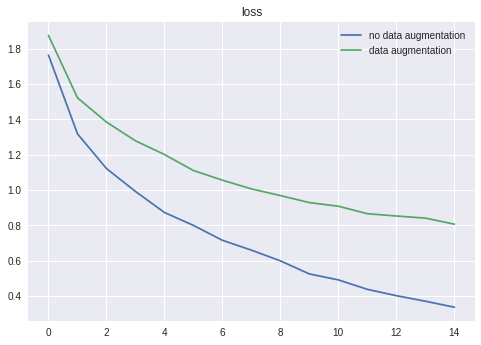

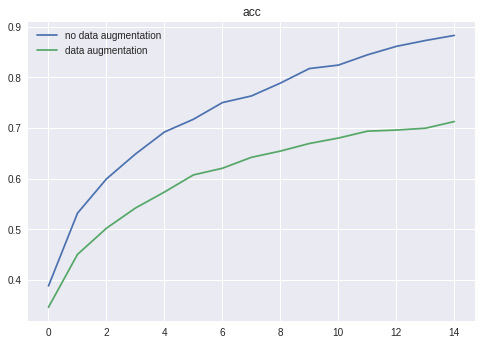

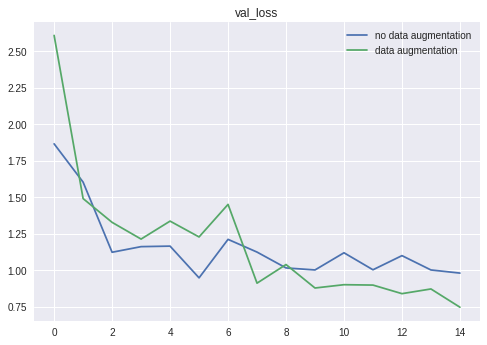

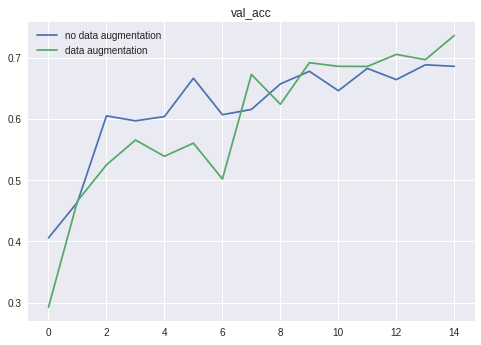

In [20]:
#@title Model Result { vertical-output: true }
import matplotlib.pyplot as plt

# training loss
for i in model_result['loss'].keys():
  plt.plot(np.arange(len(model_result['loss'][i])), model_result['loss'][i], label = i)

plt.legend(loc='best')
plt.title('loss')
plt.show()

# training acc
for i in model_result['acc'].keys():
  plt.plot(np.arange(len(model_result['acc'][i])), model_result['acc'][i], label = i)

plt.legend(loc='best')
plt.title('acc')
plt.show()

# valid loss
for i in model_result['val_loss'].keys():
  plt.plot(np.arange(len(model_result['val_loss'][i])), model_result['val_loss'][i], label = i)

plt.legend(loc='best')
plt.title('val_loss')
plt.show()


# valid acc
for i in model_result['val_acc'].keys():
  plt.plot(np.arange(len(model_result['val_acc'][i])), model_result['val_acc'][i], label = i)

plt.legend(loc='best')
plt.title('val_acc')
plt.show()